In [2]:
# execute in Colab once per session to install packages
!pip install torchinfo

In [19]:
# imports and settings
import seaborn as sns
from pandas import DataFrame, melt
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torchinfo import summary # NEW import

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plot settings
sns.set_style('white')
plt.rcParams['figure.dpi'] = 100

# Build a NN to classify all digits in the MNIST Dataset (and a CNN!)

The MNIST dataset is large collection of hanwritten digits, 0--9, represented as 28x28 grayscale images with values ranging from 0 (black) to 255 (white).

We're going to modify our MNIST binary classification example from last time.  I've also reorganized the steps a little.  Here's an outline.  The details will be repeated in each section.

* Step 1 - Data Engineering
    * Download MNIST dataset from `torchvision`
    * Understand what's in the dataset (PIL images)
    * **Add a transform to get PyTorch tensors**
    * Test a data loader with a small batch size

* Step 2 - Build our Model
    * Change the output layer to have 10 outputs
    * (Implicitly) change the sigmoid activation to a **softmax activation**
    * **Inspect our model using `torchinfo`**

* Step 3 - Train the Model
    * This time, we'll use the **Adam optimizer** (Adaptive Moment Estimation)
        * SGD suffers from slow learning.  To remedy this, Adam adapts the learning rates for each parameter by combining techniques from a couple of different optimizers.  At its heart, it's still based on gradients, but the information from the gradients is used a little differently to update the network parameters.
    * **Change the loss function to `CrossEntropyLoss`**
    * We also need to **change our method for making predictions from the network output**.

* Step 4 - Visualize the Results


## Step 1 - Data Engineering

Prepare the data and build PyTorch Datasets and Dataloaders for training and validation sets.

    * Download MNIST dataset from `torchvision`
    * Understand what's in the dataset (PIL images)
    * **Add a transform to get PyTorch tensors**
    * Test a data loader with a small batch size

### Download the data

In this case it's already a PyTorch Dataset, we just have to understand it!

In [4]:
mnist_train = MNIST(root='./data', train = True, download = True, transform = None)
mnist_valid = MNIST(root='./data', train = False, download = True, transform = None)

100%|██████████| 9912422/9912422 [00:00<00:00, 94076104.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58322433.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30971716.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20595166.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We didn't actually look at the data last time to discover its format.  Internally, the Dataset stores the images and labels as PyTorch tensors:

In [5]:
print(mnist_train.data.shape)
print(mnist_train.data.dtype)
print(mnist_train.targets.shape)
print(mnist_train.targets.dtype)

torch.Size([60000, 28, 28])
torch.uint8
torch.Size([60000])
torch.int64


But we don't usually access those tensors directly.  Instead our Dataloader will use the `__getitem__` method from the Dataset to fetch each object from its index.  The `__getitem__` method doesn't return tensors:

In [6]:
input, target = mnist_train.__getitem__(27)
print( type( input ) )
print( type( target ) )
print( target )
input

<class 'PIL.Image.Image'>
<class 'int'>
3


### Transforms

If we specify one or more Transforms from the `torchvision` package, these will be applied by Dataloader before adding the data to our batch.  We'll use the `ToTensor` transform to convert the inputs (images) to PyTorch Tensors.  Later, we'll use sequences of transforms for image augmentation.

In [7]:
mnist_train = MNIST(root='./data', train = True, download = True, transform = ToTensor() )
mnist_valid = MNIST(root='./data', train = False, download = True, transform = ToTensor() )

Fetch a single data pair and inspect again:

In [8]:
input,target = mnist_train.__getitem__(27)

print(type(target))
print(target)

<class 'int'>
3


The `ToTensor` transform didn't change the label so the Dataloader will handle that later, but it does change the image:

In [9]:
print(type(input))
print(input.shape)
input[0,5:10,5:10]

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1529, 0.6196, 0.6196, 0.6196],
        [0.0000, 0.8863, 0.9922, 0.9922, 0.9922],
        [0.0000, 0.5451, 0.9922, 0.9922, 0.9922],
        [0.0000, 0.1529, 0.1333, 0.1333, 0.1333]])

Notice the pixel values have already been normalized.

### Test a Dataloader:

In [10]:
train_loader = DataLoader(mnist_train,batch_size=4, shuffle=True)
inputs, targets = next( iter( train_loader ) )
print(inputs.shape)
print(inputs.dtype)
print(targets.shape)
print(targets.dtype)

torch.Size([4, 1, 28, 28])
torch.float32
torch.Size([4])
torch.int64


## Step 2 - Build the NN

We'll continue to use a single hidden layer.  The model from last time is below, we'll need to make a few modifications:

* Input Layer: 784 inputs (as before, but must flatten the incoming tensors with `NN.flatten`)
* Hidden Layer: 128 neurons + ReLU activation
* Output Layer: 10 neurons (with an implied softmax activation that's included in the loss function, so remove the sigmoid).

Make the necessary modifications below:

In [11]:
class MNISTall(nn.Module):
    '''
    This is a simple classification network with a single hidden layer.
    '''
    def __init__(self, nInputs, nHidden, nOutputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nInputs, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutputs),
        )

    def forward(self, x):
        return(self.layers(x))

In [12]:
nInputs = 784
nHidden = 128
nOutputs = 10
model = MNISTall(nInputs, nHidden, nOutputs).to(device)
model

MNISTall(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Let's test it on the small batch from `train_loader`

In [14]:
inputs, targets = next( iter( train_loader ) )
inputs = inputs.to(device)
outputs = model( inputs )

inputs.shape, outputs.shape, targets.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4, 10]), torch.Size([4]))

Something strange happened there.  The network has 10 outputs, but the labels are integers.  
To get the prediction we need to find which of the 10 outputs is largest (or equivalently has the largest softmax value).

### Use Torchinfo to see the model structure

With `torchinfo.summary()` you specify the shape of an input batch and it shows you the dimensions of the inputs and outputs of each layer in addition to the number of parameters.  It's really useful for checking your network structure:

In [15]:
batch_size = 50
summary(model, input_size = (batch_size,1,28,28),
        col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTall                                 [50, 1, 28, 28]           [50, 10]                  --
├─Sequential: 1-1                        [50, 1, 28, 28]           [50, 10]                  --
│    └─Flatten: 2-1                      [50, 1, 28, 28]           [50, 784]                 --
│    └─Linear: 2-2                       [50, 784]                 [50, 128]                 100,480
│    └─ReLU: 2-3                         [50, 128]                 [50, 128]                 --
│    └─Linear: 2-4                       [50, 128]                 [50, 10]                  1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 5.09
Input size (MB): 0.16
Forward/backward pass size (MB): 0.06
Params size (MB): 0.41
Estimated Total Size (MB): 0.62

## Step 3 - Train the model

Below is the training loop from last time.  We'll need to make a few changes:

* change the model
* change the loss function to `CrossEntropyLoss` from the `nn` module
* use the Adam optimizer and maybe lower the learning rate (Adam defaults to 0.001)
* to make predictions from the outputs for computing accuracy, we need the index of the largest output
    * `_, prediction = torch.max(outputs.detach().data, 1)`

In [16]:
##################################################
## training the model
##################################################

epochs = 20
outputInterval = 1
learningRate = 0.001
batchSize = 600
nInputs = 784
nHidden = 128
nOutputs = 10

# Create a new instance of the model to randomize the weights each time
#torch.manual_seed(40)
model = MNISTall(nInputs, nHidden, nOutputs).to(device)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(mnist_train, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(mnist_valid, batch_size=batchSize, shuffle=False)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Initialize lists to losses for later plotting
loss_train_list = []
loss_valid_list = []

# Run the training loop
for epoch in range(epochs):

    # Training Phase
    model.train()
    loss_train = 0.0
    correct_train = 0
    num_train = 0

    for inputs, targets in train_dataloader:

        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # one training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        # accumulate accuracy and loss
        loss_train += loss.item()
        _, prediction = torch.max(outputs.detach().data, 1)
        correct_train += (prediction == targets).sum().item()
        num_train += len(outputs)

    acc_train = 100 * correct_train / num_train
    loss_train = loss_train / num_train
    loss_train_list.append(loss_train)

    # Validation phase
    model.eval()
    loss_valid = 0.0
    correct_valid = 0
    num_valid = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:

            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # predictions and loss
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # accumulate accuracy and loss
            loss_valid += loss.item()
            _, prediction = torch.max(outputs.detach().data, 1)
            correct_valid += (prediction == targets).sum().item()
            num_valid += len(outputs)

    acc_valid = 100 * correct_valid / num_valid
    loss_valid = loss_valid / num_valid
    loss_valid_list.append(loss_valid)

    if (epoch + 1) % outputInterval == 0:
        print( (f'At epoch {epoch+1} '
                f'train_loss = {loss_train:.3e}, '
                f'val_loss = {loss_valid:.3e}, '
                f'acc_train = {acc_train:.2f}% '
                f'acc_valid = {acc_valid:.2f}%' ) )

At epoch 1 train_loss = 1.253e-03, val_loss = 5.615e-04, acc_train = 82.88% acc_valid = 90.97%
At epoch 2 train_loss = 4.962e-04, val_loss = 4.425e-04, acc_train = 91.63% acc_valid = 92.75%
At epoch 3 train_loss = 3.994e-04, val_loss = 3.685e-04, acc_train = 93.16% acc_valid = 94.00%
At epoch 4 train_loss = 3.356e-04, val_loss = 3.155e-04, acc_train = 94.39% acc_valid = 94.65%
At epoch 5 train_loss = 2.895e-04, val_loss = 2.798e-04, acc_train = 95.05% acc_valid = 95.31%
At epoch 6 train_loss = 2.518e-04, val_loss = 2.469e-04, acc_train = 95.70% acc_valid = 95.85%
At epoch 7 train_loss = 2.213e-04, val_loss = 2.264e-04, acc_train = 96.19% acc_valid = 96.23%
At epoch 8 train_loss = 1.955e-04, val_loss = 2.078e-04, acc_train = 96.70% acc_valid = 96.53%
At epoch 9 train_loss = 1.765e-04, val_loss = 1.964e-04, acc_train = 96.98% acc_valid = 96.64%
At epoch 10 train_loss = 1.583e-04, val_loss = 1.873e-04, acc_train = 97.28% acc_valid = 96.88%
At epoch 11 train_loss = 1.435e-04, val_loss = 1.

## Step 4 - Visualize the results

Plot the training and validation loss versus epochs.

Go back to the training loop and add the ability to record the training and validation accuracy at each step, then plot those too.

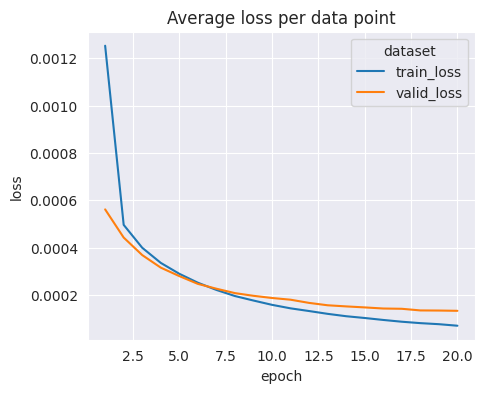

In [20]:
def plot_losses(train_loss, valid_loss):
  train_loss = np.array(train_loss)
  valid_loss = np.array(valid_loss)
  epoch = np.arange(1,len(train_loss)+1)
  data_wide = DataFrame({'epoch':epoch,'train_loss':train_loss,'valid_loss':valid_loss})
  data_long = melt(data_wide, ['epoch'], var_name = 'dataset', value_name = 'loss')
  fig,axis = plt.subplots( figsize = (5,4) )
  sns.lineplot( ax = axis, data = data_long, x = 'epoch', y = 'loss', hue = 'dataset')
  axis.set_title('Average loss per data point')

sns.set_style('darkgrid')
plot_losses(loss_train_list, loss_valid_list)

## In-class exercise

Now copy the model and training loop into new cells below.

Modify the model so that it has two hidden layers with ReLU activation functions.  The first hidden layer should have 512 neurons and the second should have 128 neurons.    

How many parameters does this model have? (use `torchinfo.summary()` as above)  How does that compare to the previous model?

How high is the accuracy on the new model?

# Our first CNN

A convolutional network for images will expect 3D tensors as input.  The three dimensions represent channels, height, and width.  The number of channels will be 1 for grayscale images, like MNIST, and 3 for color images stored in RGB format.

In PyTorch `nn.Conv2d` is described as "applies a 2D convolution over an input signal composed of several input plane."  This sounds like what we need to apply convolutions to images in PyTorch `nn.Module`.  Here's the function signature from the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

We'll restrict our attention to the first 5 inputs and leave the rest at their defaults.
* in_channels:  the number of input channels or the number of "features" from the previous layer
* out_channels:  how many channels or features you want this layer to produce
* kernel_size:  bigger kernels use non-local information and are more computationally complex.  Simple networks will use 3 or 5.
* stride:  how much to move the "sliding window" during the convolution operation.  Usually this is 1.
* padding:  how many extra rows or columns of zeros to add on each input side.

So `torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride=1, padding=2)`  would be
used to transform a 3 channel input image into 16 feature maps.  The height and width would not change.  

How many parameters would there be in this layer?

In [21]:
conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride=1, padding=2)

In [22]:
batch_size = 1
summary(conv1, input_size = (batch_size,3,64,64),
        col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Conv2d                                   [1, 3, 64, 64]            [1, 16, 64, 64]           1,216
Total params: 1,216
Trainable params: 1,216
Non-trainable params: 0
Total mult-adds (M): 4.98
Input size (MB): 0.05
Forward/backward pass size (MB): 0.52
Params size (MB): 0.00
Estimated Total Size (MB): 0.58

In a fully connected neural network we used `Linear` layers followed by nonlinear activation functions like `ReLU` and then repeated that pattern for multiple hidden layers.

For a typical CNN the basic pattern or building block is:
*  convolutional layer (`Conv2d` for images)
*  `ReLU` activation
*  a max pooling layer (`MaxPool2d` for images - assigned reading for next class)

Here is an image of a basic CNN for image classification.  Source: [Convolutional Neural Networks: An Overview](https://www.analyticsvidhya.com/blog/2022/01/convolutional-neural-network-an-overview/):


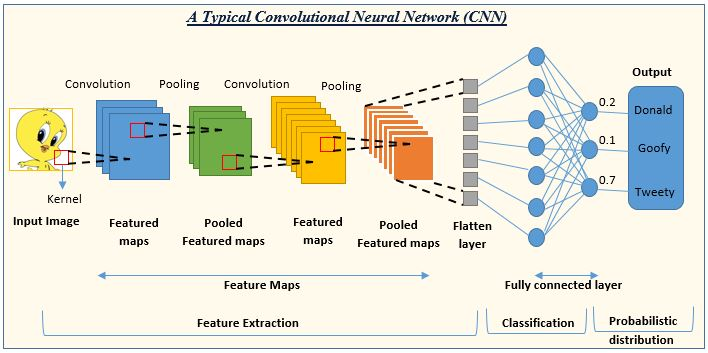

### Visualizing a CNN

Before we implement a CNN in PyTorch, we'll take a detour to a visual demo of a CNN called [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

### Implementing a CNN in PyTorch


Below is an example copied from the an article/tutorial: [PyTorch Convolutional Neural Network With MNIST Dataset](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118).  Its overall structure is the same as that in the picture.

I've made only minor modifications:

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

(Discuss the above model in class.  Compare to putting all the layers inside a one `Sequential` block.)



Here is a version of the model with all the layers packed into a single `Sequential` block.  

BONUS:  for simple feed-forward networks you can **define** the model using a `Sequential` block without forming a `nn.Module`!

In [28]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
            ),
    nn.ReLU(),
    nn.MaxPool2d( kernel_size = 2),
    nn.Conv2d(16, 32, 5, 1, 2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32*7*7,10),
)

To check to see if we've set this up correctly, or at least consistently, let's use `torchinfo.summary` to see what our model does to a small batch:

In [25]:
batch_size = 1
summary(model, input_size = (batch_size,1,28,28),
        col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [1, 1, 28, 28]            [1, 10]                   --
├─Conv2d: 1-1                            [1, 1, 28, 28]            [1, 16, 28, 28]           416
├─ReLU: 1-2                              [1, 16, 28, 28]           [1, 16, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 16, 28, 28]           [1, 16, 14, 14]           --
├─Conv2d: 1-4                            [1, 16, 14, 14]           [1, 32, 14, 14]           12,832
├─ReLU: 1-5                              [1, 32, 14, 14]           [1, 32, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 32, 14, 14]           [1, 32, 7, 7]             --
├─Flatten: 1-7                           [1, 32, 7, 7]             [1, 1568]                 --
├─Linear: 1-8                            [1, 1568]                 [1, 10]                   15,690
Total params: 28,938
Train

OK, at least all the dimensions make sense.  Let's try applying the model to a small batch from our training Dataloader:

In [26]:
inputs, targets = next( iter( train_loader ) )
inputs = inputs.to(device)
outputs = model( inputs )

inputs.shape, outputs.shape, targets.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4, 10]), torch.Size([4]))

In [30]:
##################################################
## training the model
##################################################

epochs = 20
outputInterval = 1
learningRate = 0.001
batchSize = 600
nInputs = 784
nHidden = 128
nOutputs = 10

# Create a new instance of the model to randomize the weights each time

#### Use the model from the previous cell but move it the current device
model = model.to(device)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(mnist_train, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(mnist_valid, batch_size=batchSize, shuffle=False)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Initialize lists to losses for later plotting
loss_train_list = []
loss_valid_list = []

# Run the training loop
for epoch in range(epochs):

    # Training Phase
    model.train()
    loss_train = 0.0
    correct_train = 0
    num_train = 0

    for inputs, targets in train_dataloader:

        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # one training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        # accumulate accuracy and loss
        loss_train += loss.item()
        _, prediction = torch.max(outputs.detach().data, 1)
        correct_train += (prediction == targets).sum().item()
        num_train += len(outputs)

    acc_train = 100 * correct_train / num_train
    loss_train = loss_train / num_train
    loss_train_list.append(loss_train)

    # Validation phase
    model.eval()
    loss_valid = 0.0
    correct_valid = 0
    num_valid = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:

            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # predictions and loss
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # accumulate accuracy and loss
            loss_valid += loss.item()
            _, prediction = torch.max(outputs.detach().data, 1)
            correct_valid += (prediction == targets).sum().item()
            num_valid += len(outputs)

    acc_valid = 100 * correct_valid / num_valid
    loss_valid = loss_valid / num_valid
    loss_valid_list.append(loss_valid)

    if (epoch + 1) % outputInterval == 0:
        print( (f'At epoch {epoch+1} '
                f'train_loss = {loss_train:.3e}, '
                f'val_loss = {loss_valid:.3e}, '
                f'acc_train = {acc_train:.2f}% '
                f'acc_valid = {acc_valid:.2f}%' ) )

At epoch 1 train_loss = 1.061e-03, val_loss = 3.400e-04, acc_train = 82.82% acc_valid = 94.19%
At epoch 2 train_loss = 2.399e-04, val_loss = 1.658e-04, acc_train = 95.86% acc_valid = 97.15%
At epoch 3 train_loss = 1.549e-04, val_loss = 1.166e-04, acc_train = 97.29% acc_valid = 97.87%
At epoch 4 train_loss = 1.202e-04, val_loss = 9.328e-05, acc_train = 97.83% acc_valid = 98.32%
At epoch 5 train_loss = 9.926e-05, val_loss = 8.592e-05, acc_train = 98.18% acc_valid = 98.44%
At epoch 6 train_loss = 8.512e-05, val_loss = 6.916e-05, acc_train = 98.48% acc_valid = 98.76%
At epoch 7 train_loss = 7.851e-05, val_loss = 6.745e-05, acc_train = 98.58% acc_valid = 98.79%
At epoch 8 train_loss = 6.902e-05, val_loss = 6.424e-05, acc_train = 98.74% acc_valid = 98.85%
At epoch 9 train_loss = 6.183e-05, val_loss = 6.213e-05, acc_train = 98.86% acc_valid = 98.85%
At epoch 10 train_loss = 5.750e-05, val_loss = 5.476e-05, acc_train = 98.94% acc_valid = 98.92%
At epoch 11 train_loss = 5.233e-05, val_loss = 5.